## Building stacked lensing profile including effects of triaxiality.
### Zhuowen Zhang
#### Updated Sept. 4 2018

In [2]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir
import pyfits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/redM_Buzzard/'
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param

### Import Halo File

In [4]:
#Import the redM_matched Buzzard halos
#Read from redM_matched halos
redM_dir = homedir + 'output/buzzard/'+'halo_redM_matched.dat'

#Field names of the files from first row of file. Shoule be:
#('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', 'halos_ID', 'halos_RA', 'halos_DEC', 
#'halos_z', 'halos_X', 'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir')
redM_halos = np.genfromtxt(redM_dir, dtype ="i, f8, f8, f8, f8, i, f8, f8, f8, f8, f8, f8, f8, f8, f8", \
                  unpack=True, usecols=range(0,15), names=True)
redM_halos = redM_halos.view(np.recarray)

print "Names of redM_matched halo column data are:"
print redM_halos.dtype.names, "\n"
print "Number of halos read is ", len(redM_halos)

Names of redM_matched halo column data are:
('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', 'halos_ID', 'halos_RA', 'halos_DEC', 'halos_z', 'halos_X', 'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir') 

Number of halos read is  23998


In [11]:
from repo.halo_shape.read_shape_param import read_shape_param

filename = 'halo_shape_allz.npy'
halo_shape = np.load(shapedir+filename)
print halo_shape.dtype
convcut = np.where(halo_shape['converge'] == True)[0]
halo_shape = halo_shape[convcut]
haloid, q, s, cos_i =  read_shape_param(halo_shape)
richness = halo_shape['richness']
halos_M = halo_shape['M200b']
halos_RA = halo_shape['halos_RA']
halos_DEC = halo_shape['halos_DEC']

'''
#Match with the shape catalog and add shape parameters
#dummy = np.isin(redM_halos.halos_ID, haloid)
dummy = np.nonzero(np.in1d(redM_halos.halos_ID, haloid))[0]
print redM_halos.halos_ID[dummy], haloid
redM_halos = redM_halos[dummy]
'''


#coordinates to input to kmeans
halos_coord = np.zeros( (len(halos_RA),2))
halos_coord[:,0] = halos_RA; halos_coord[:,1] = halos_DEC

print "Number of halos is ", len(q)

[('halos_ID', '<i4'), ('richness', '<f4'), ('M200b', '<f4'), ('Rvir', '<f4'), ('redshift', '<f4'), ('axes_len', '<f4', (3,)), ('axes_dir', '<f4', (3, 3)), ('halos_dir', '<f4', (3,)), ('halos_RA', '<f4'), ('halos_DEC', '<f4'), ('converge', '<i4')]
Number of halos is  23703


### Bin by cosi and richness

In [12]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind = halo_bin_stat(cos_i, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind = halo_bin_stat(richness, lmda_bins)
lnM_lmda_binned = np.zeros_like(lmda_bins_ind)
lnM_lmda_binned = np.array([np.log(halos_M[lmda_bins_ind[x]]) for x in range(len(lmda_bins_ind))])

#print lnM_lmda_binned
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q))]

Maximum richness after cuts is  303.044


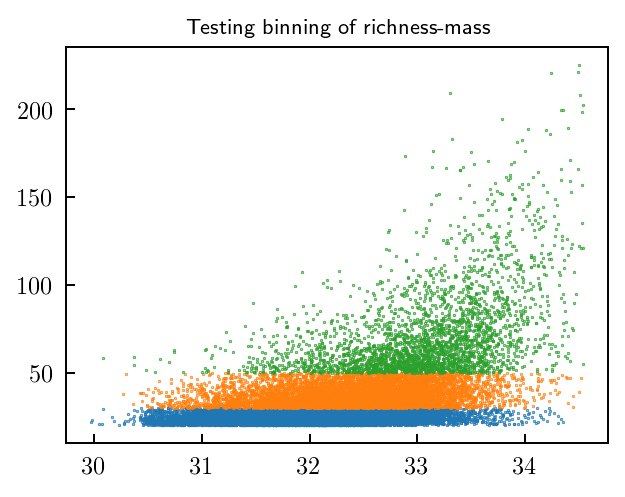

In [4]:
#Check properly binned by reproducing the richness-mass relation
plt.figure(figsize=(4,3))
plt.title(r'Testing binning of richness-mass', fontsize=9)
for i in range(3):
    plt.scatter(lnM_lmda_binned[i], richness[lmda_bins_ind[i]], s=0.1)
    
plt.show()

### Importing functions from DS_functions. These include:

#### 1. Best fit parameters of richness-mass A, B, sig0
Using model3 (vary A only, best fit of B, \sigma found from model2) interpolate lnA using spline with no smoothing.
#### 2. prob_lambda: using best fit params calculates prob of finding lnl given lnM from theoretical prediction. 
#### 3. lnDS_ratio: Heidi's template for orientation dependence of DeltaSigma


In [13]:
from repo.surface_density.DS_functions import interpolate_A, bestfit_A, bestfit_B, bestfit_sig0
from repo.surface_density.DS_functions import prob_lambda
from repo.surface_density.DS_functions import lnDS_ratio


cosi_mid, spl_lnA, data_lnA = interpolate_A(tpltdir, cosi_bins)
allfit_A = bestfit_A(tpltdir)
allfit_B = bestfit_B(tpltdir)
allfit_sig0 = bestfit_sig0(tpltdir)

print "best fit global lnA, B, sig0 are", np.log(allfit_A), allfit_B, allfit_sig0

best fit global lnA, B, sig0 are 2.760345718144925 0.8672562498926204 0.4646067757219166


### Power Spectrum from CLASS
The power spectrum is cosmology dependent. Need to adapt if you are changing cosmology for different runs. 

In [14]:
#Build the cosmology
from classy import Class
import numpy as np

#Start by specifying the cosmology
Omega_b = 0.045714
Omega_cdm = 0.238
Omega_m = Omega_b + Omega_cdm
h = 0.70
A_s = 2.1e-9
n_s = 0.951

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc
params = {
             'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'h':h,
             'A_s':A_s,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}

In [15]:
#Initialize the cosmology and compute power spectrum
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k_ps = np.logspace(-5, np.log10(k_max), num=1000) #Mpc^-1
z = 0.1

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k_ps])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k_ps])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k_ps /= h
Plin *= h**3
Pnonlin *= h**3

### Calculate the 1-halo and 2-halo halo-matter correlation 

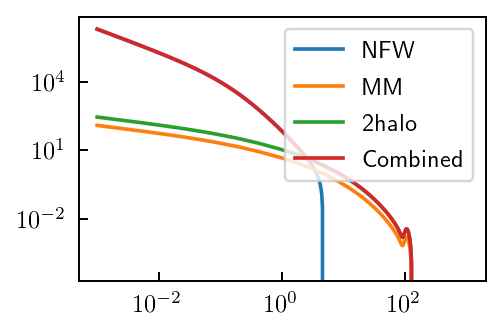

In [13]:
from cluster_toolkit import xi
from cluster_toolkit import bias
#Individual surface density
concentration = 5 #nominal concentration
mass = 1e14
radii = np.logspace(-3,3,500)

#Halo-matter correlation
xi_nfw = xi.xi_nfw_at_R(radii, mass, concentration, Omega_m)
#k and P come from CLASS
xi_mm = xi.xi_mm_at_R(radii, k_ps, Plin)
bias = bias.bias_at_M(mass, k_ps, Plin, Omega_m)
xi_2halo = xi.xi_2halo(bias, xi_mm)
xi_hm = xi.xi_hm(xi_nfw, xi_2halo)
    
plt.figure(figsize=(3,2))
plt.plot(radii, xi_nfw, label='NFW')
plt.plot(radii, xi_mm, label='MM')
plt.plot(radii, xi_2halo, label='2halo')
plt.plot(radii, xi_hm, label='Combined')
plt.yscale('log'); plt.xscale('log')
plt.legend()
plt.show()


### Testing Halo Mass Function
Testing new code. Build this when come back. 

shapecut for hrun completed in halo_mass_template


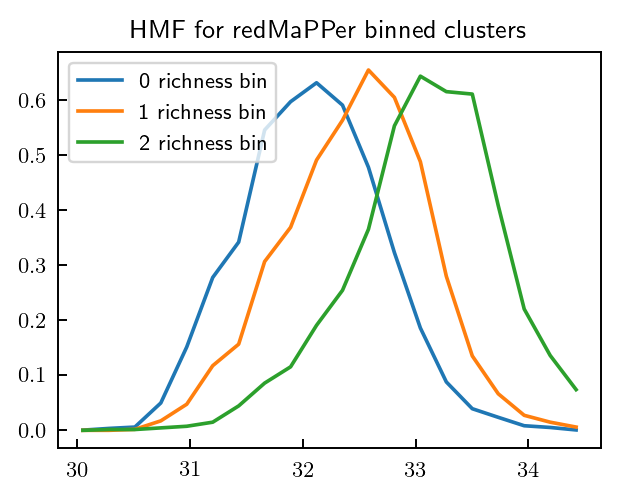

In [16]:
from tools.halo_mass_template import redMaPPer_hmf

num_bins = 20
lnM = np.linspace(13*np.log(10), 15*np.log(10), num_bins)

plt.figure(figsize=(4,3))
for i in range(3):
    dndlnm, cen_bin = redMaPPer_hmf(lnM, num_bins = num_bins, lmda_bin = i)
    plt.plot(cen_bin, dndlnm, label='{} richness bin'.format(i))
plt.title('HMF for redMaPPer binned clusters')
plt.legend()
plt.show()

### Individual Surface Density Profiles (for testing)

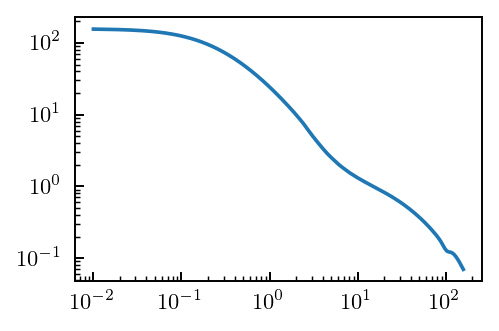

In [17]:
from cluster_toolkit import deltasigma
mass = 1e14 #Msun/h
concentration = 5 #arbitrary
r = np.logspace(-2,2.2,200)
#radii = np.logspace(-3,3,500) #radii has to match the radii used for calculating xi_hm
#halo-matter correlation calculated above
Sigma = deltasigma.Sigma_at_R(r, radii, xi_hm, mass, concentration, Omega_m)
DS_bar = deltasigma.DeltaSigma_at_R(r, r, Sigma, mass, concentration, Omega_m)
plt.figure(figsize=(3,2))
plt.plot(r, DS_bar)
plt.yscale('log'); 
plt.xscale('log')
plt.show()

### Stacked Lensing Profiles
#### TODO! Need to adapt the concentration to e.g. Tinker to match concentration-mass relation

In [17]:
from cluster_toolkit import xi
from cluster_toolkit import bias
from scipy.integrate import nquad
from time import time
from cluster_toolkit import deltasigma


'''
Integrand for stacked DS profile across richness bins. See section 5.2 triaxiality paper.
Sigma profile of halo using nfw for nominal concentration of 5. 

lnM: Mass in log Msun/h
lnl log(richness)
mu=cosi from 0 to 1
lmda_bin = 0,1,2 the lambda bin to calculate halo mass funttion for matched halos
r = array of projected radius in Mpc/h
Orientation: True for orientation dependent model, False for w/o dependence. Need to input mu nonetheless.

Outputs:
the integrand for stacked DS for a range of projected sky radius
'''
def stacked_DS_integrand(lnM, lnl, mu, r,  radii, xi_hm, concentration=5, lmda_bin=0, orientation=True):
    global k_ps
    global Plin
    #r = np.logspace(-2,2,100)
    #Shift in richness-mass relationship
    mass =np.exp(lnM)
    
    if orientation == True:
        prob_lnl = prob_lambda(lnl, lnM, mu=mu)
    else:
        prob_lnl = prob_lambda(lnl, lnM, mu=None)
    
    #Individual surface density
    #concentration = 5 #nominal concentration

    x = np.log(r)
    Sigma = deltasigma.Sigma_at_R(r, radii, xi_hm, mass, concentration, Omega_m)
    DS_bar = deltasigma.DeltaSigma_at_R(r, r, Sigma, mass, concentration, Omega_m)
    
    if orientation:
        DS_mu = np.exp(lnDS_ratio(mu, x)) * DS_bar
    else:
        DS_mu = DS_bar
    #spl_DS_mu = spline(r, DS_mu, s=0.0)
    
    #Calculating the mass function
    #dndlnM = P_Mhalo_matched(lnM, lmda_bin = lmda_bin)[0]
    dndlnM, cen_bin = redMaPPer_hmf(lnM, lmda_bin=lmda_bin)
    
    return prob_lnl*DS_mu*dndlnM

#### Computing stacked DS

In [19]:
#Build Tabulated integral

num_int = 10
lnM_range = np.log(10)*np.linspace(13.0,15.2,num_int); dlnM = lnM_range[1]- lnM_range[0]
mu_range = np.linspace(0.,1.,num_int); dmu = mu_range[1]- mu_range[0]

r_num = 100
DS_stacked_cosi = np.zeros((3, 1, r_num)) #orientation dependence #Change back to [len(c_arr), len(lmda_bins), r_num]
DS_stacked_avg = np.zeros((3, 1, r_num)) #no orientation dependence
r = np.logspace(-2,2,r_num)

###This need to change
#lnl_range = np.log(np.linspace(lmda_bins[0][0], lmda_bins[0][1], num_int)); dlnl = lnl_range[1]- lnl_range[0]    

#Modify the concentration
c_arr = np.array([1, 5, 10])

lmda_bins = [[20,30]]

for p, c_cur in enumerate(c_arr):
    print "Concentration is ", c_cur
    for l in range(1): #range(len(lmda_bins)):
        print "Lambda bin \n", l
        lnl_range = np.log(np.linspace(lmda_bins[l][0], lmda_bins[l][1], num_int)); dlnl = lnl_range[1]- lnl_range[0]    
        for i, ilnM in enumerate(lnM_range):
            print 'Mass bin', i
            #Calculate halo-matter correlation for different mass bins
            mass = np.exp(ilnM)
            radii = np.logspace(-3,3,500)
            concentration = c_cur #nominal concentration
            xi_nfw = xi.xi_nfw_at_R(radii, mass, concentration, Omega_m)
            #Assume that k and P come from somewhere, e.g. CAMB or CLASS
            xi_mm = xi.xi_mm_at_R(radii, k_ps, Plin)
            hbias = bias.bias_at_M(mass, k_ps, Plin, Omega_m)
            xi_2halo = xi.xi_2halo(hbias, xi_mm)
            xi_hm = xi.xi_hm(xi_nfw, xi_2halo)

            for j, jlnl in enumerate(lnl_range):
                for k, kmu in enumerate(mu_range):       
                    #Calculate stacked density
                    DS_stacked_cosi[p,l] += stacked_DS_integrand(ilnM, jlnl, kmu, r, radii, xi_hm, concentration=c_cur, lmda_bin=l, orientation=True)
                    DS_stacked_avg[p,l] += stacked_DS_integrand(ilnM, jlnl, kmu, r, radii, xi_hm, concentration=c_cur, lmda_bin=l, orientation=False)
                       
    DS_stacked_cosi[p] *= dlnM * dlnl * dmu 
    DS_stacked_avg[p] *= dlnM * dlnl * dmu 

Concentration is  1
Lambda bin 
0
Mass bin 0
Mass bin 1
Mass bin 2
Mass bin 3
Mass bin 4
Mass bin 5
Mass bin 6
Mass bin 7
Mass bin 8
Mass bin 9
Concentration is  5
Lambda bin 
0
Mass bin 0
Mass bin 1
Mass bin 2
Mass bin 3
Mass bin 4
Mass bin 5
Mass bin 6
Mass bin 7
Mass bin 8
Mass bin 9
Concentration is  10
Lambda bin 
0
Mass bin 0
Mass bin 1
Mass bin 2
Mass bin 3
Mass bin 4
Mass bin 5
Mass bin 6
Mass bin 7
Mass bin 8
Mass bin 9


### Plotting

Text(0.5,0,'\\textrm{R} [$h^{-1}~$\\textrm{Mpc}]')

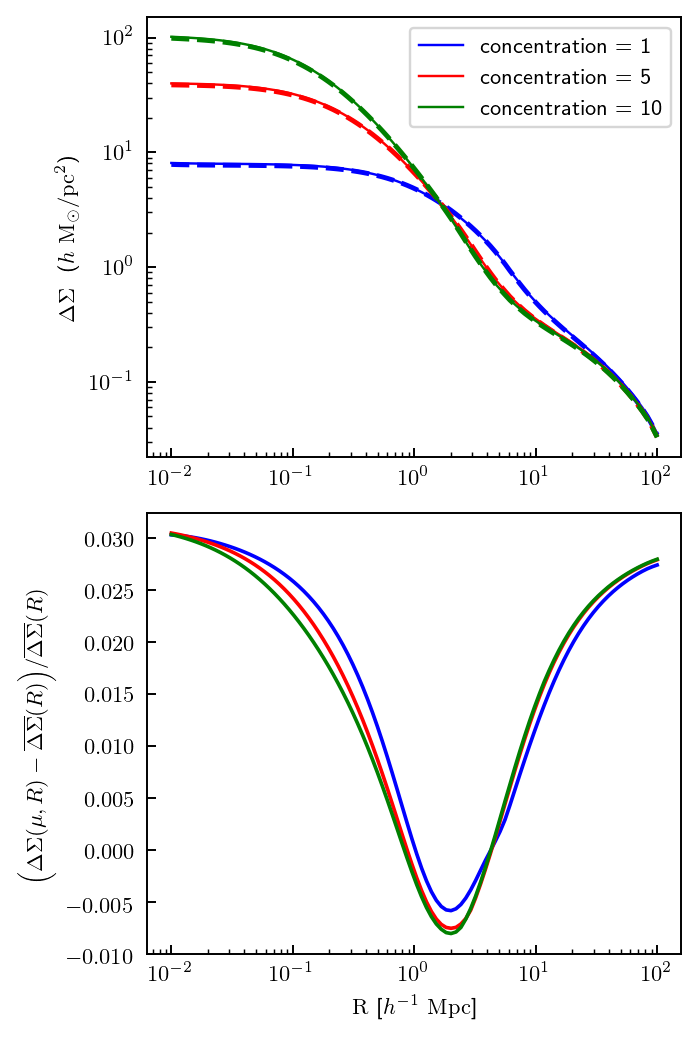

In [27]:
fig, axs = plt.subplots(2,1, tight_layout=True, figsize=(4,6))

#Plot the fractional difference
c_list = ['b', 'r', 'g']
for i in range(3): #This is for different concentration
    #plt.plot(r, DS_stacked_cosi[i], label="True {}".format(lmda_bins[i]))
    diff = (DS_stacked_cosi[i,0]-DS_stacked_avg[i,0])/DS_stacked_avg[i,0]
    axs[0].plot(r, DS_stacked_cosi[i,0], label= \
        "concentration = {}".format(c_arr[i]), color=c_list[i], linewidth=1)       
        #"$\lambda \in [{:.1f},{:.1f}) $".format(lmda_bins[i][0], lmda_bins[i][1]),color=c_list[i], linewidth=1)
    
    axs[0].plot(r, DS_stacked_avg[i,0], linestyle='dashed', color=c_list[i], linewidth=2)
    
axs[0].set_xscale('log'); axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_ylabel(r"$\Delta\Sigma~$ ($h$ \textrm{M}$_{\odot}$/\textrm{pc}$^2$)")
#axs[0].set_xlabel(r"\textrm{R} [$h^{-1}~$\textrm{Mpc}]"  )
#plt.savefig('DS_orientation_dependence.png')
#plt.show()

#Plot the fractional difference
for i in range(3):
    #plt.plot(r, DS_stacked_cosi[i], label="True {}".format(lmda_bins[i]))
    diff = (DS_stacked_cosi[i,0]-DS_stacked_avg[i,0])/DS_stacked_avg[i,0]
    axs[1].plot(r, diff, \
                    label="concentration = {}".format(c_arr[i]), color=c_list[i])       
                #label="$\lambda \in [{:.1f},{:.1f}) $".format(lmda_bins[i][0], lmda_bins[i][1]), color=c_list[i])
axs[1].set_xscale('log'); #axs[1].set_yscale('log')
#plt.legend()
axs[1].set_ylabel(r"$\big(\Delta\Sigma(\mu, R)-\overline{\Delta\Sigma}(R)\big)/\overline{\Delta\Sigma}(R)$")
axs[1].set_xlabel(r"\textrm{R} [$h^{-1}~$\textrm{Mpc}]"  )
#plt.savefig('DS_diff_cosi_dependence.png')
#r = np.logspace(-2,2,100)
#print stacked_DS